In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

use_ema=True
tikr='JNJ'

_stock_price_history=yf.Ticker(tikr).history(start='2022-01-01')#,end='2021-01-01')
_stock_price_history.dropna(inplace=True)

In [2]:
# Strategy to find optimal moving average window combinations
best_return = -float('inf')
best_windows = None
window_combinations = []
results = []

sort_by='return' # or 'hit_rate'

#use_ema=False
for use_ema in [True,False]:
    # Test different window combinations
    for short_window in range(5, 30):
        for long_window in range(short_window + 1, 100):
            stock_price_history = _stock_price_history.copy()
            windows = [short_window, long_window]
            
            # Calculate moving averages
            for window in windows:
                if use_ema:
                    stock_price_history[f'MA{window}'] = stock_price_history['Close'].ewm(span=window, adjust=False, min_periods=window).mean()
                else:
                    stock_price_history[f'MA{window}'] = stock_price_history['Close'].rolling(window=window).mean()
            
            # Create signals
            stock_price_history['MA_cross'] = np.where(
                stock_price_history[f'MA{windows[0]}'] > stock_price_history[f'MA{windows[1]}'], 1, -1)
            stock_price_history['crossover'] = stock_price_history['MA_cross'].diff()
            
            # Get crossover dates
            crossover_dates = stock_price_history[stock_price_history['crossover'] != 0]
            if len(crossover_dates[crossover_dates['crossover'] == 2]) == 0 or len(crossover_dates[crossover_dates['crossover'] == -2]) == 0:
                continue
                
            first_buy_date = crossover_dates[crossover_dates['crossover'] == 2].index[0]
            last_sell_date = crossover_dates[crossover_dates['crossover'] == -2].index[-1]
            
            crossover_dates = crossover_dates.loc[first_buy_date:last_sell_date].copy()
            crossover_dates.dropna(inplace=True)
            
            # Calculate returns
            crossover_dates['return'] = np.where(crossover_dates['crossover']==2, 0, crossover_dates['Close'].pct_change())
            returns = crossover_dates['return'].to_numpy(dtype=float)
            returns = returns[returns!=0]
            
            if len(returns) > 0:
                total_return = np.prod(1+returns)-1
                hit_rate = len(returns[returns>0])/len(returns)

                if total_return>0:
                    results.append({
                        'windows': windows,
                        'return': total_return,
                        'hit_rate': hit_rate,
                        'trades': len(crossover_dates),
                        'EMA?': use_ema,
                    })
                else:
                    windows = windows[::-1]
                    total_return = -total_return
                    hit_rate = 1-hit_rate
                    results.append({
                        'windows': windows,
                        'return': total_return,
                        'hit_rate': hit_rate,
                        'trades': len(crossover_dates),
                        'EMA?': use_ema,
                    })
                    
# Sort results by return and display top 5
results_df = pd.DataFrame(results).sort_values(sort_by, ascending=False)
print("Top 5 window combinations:")
print(results_df.head())

print(f"Returns without trading:{(_stock_price_history.Close.iloc[-1]-_stock_price_history.Close.iloc[0])*100/(_stock_price_history.Close.iloc[0]):.2f}%")
print(f"Total time: {_stock_price_history.index[-1]-_stock_price_history.index[0]}")

Top 5 window combinations:
      windows    return  hit_rate  trades  EMA?
873  [78, 14]  0.278499  0.777778      18  True
369   [99, 8]  0.278195  0.916667      24  True
723  [99, 12]  0.276051  0.818182      22  True
636  [99, 11]  0.275930  0.800000      20  True
548  [99, 10]  0.274805  0.800000      20  True
Returns without trading:-3.88%
Total time: 1122 days 00:00:00


Using EMA
Strategy: Buy when MA78 > MA14, sell when MA78 < MA14
Number of trades: 16
Hit rate: 87.50%
Total time: 764 days 00:00:00


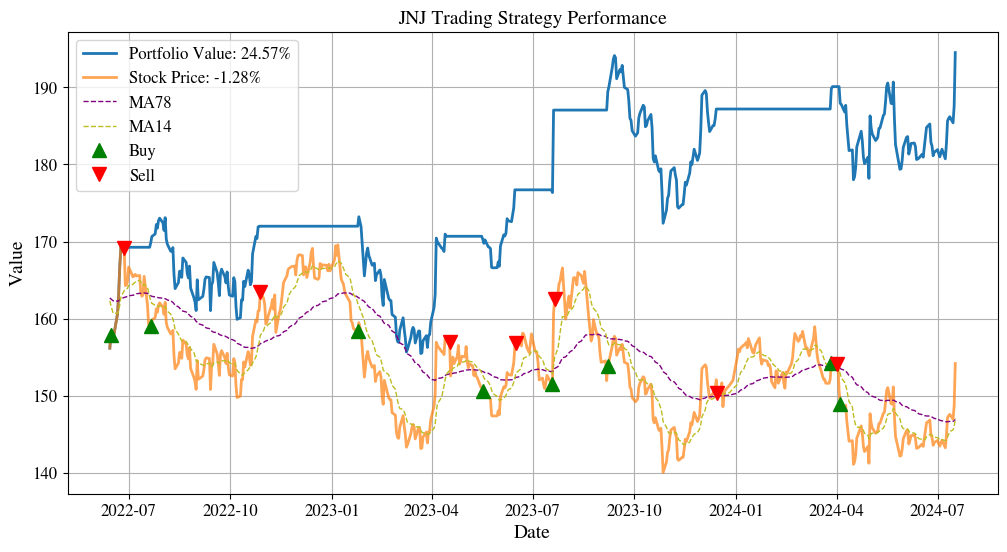

In [4]:
windows=results_df.iloc[0]['windows']
use_ema=results_df.iloc[0]['EMA?']
# when the short term moving average is above the long term moving average, the stock is considered bullish
stock_price_history=_stock_price_history.copy()

for window in windows:
    if use_ema:
        stock_price_history['MA'+str(window)]=stock_price_history['Close'].ewm(span=window, adjust=False, min_periods=window).mean()
    else:
        stock_price_history['MA'+str(window)]=stock_price_history['Close'].rolling(window=window).mean()

# Create crossover signals
stock_price_history['MA_cross'] = np.where(
    stock_price_history['MA'+str(windows[0])] > stock_price_history['MA'+str(windows[1])], 1, -1)
# Find where the signal changes (crossover points)
stock_price_history['crossover'] = stock_price_history['MA_cross'].diff()

# Get dates where crossovers occur
crossover_dates = stock_price_history[stock_price_history['crossover'] != 0]
first_buy_date = crossover_dates[crossover_dates['crossover'] == 2].index[0]
last_sell_date = crossover_dates[crossover_dates['crossover'] == -2].index[-1]

crossover_dates = crossover_dates.loc[first_buy_date:last_sell_date]
stock_price_history = stock_price_history.loc[first_buy_date:last_sell_date]
price_range=stock_price_history['Close'].max()-stock_price_history['Close'].min()


crossover_dates = crossover_dates.copy()
crossover_dates.dropna(inplace=True)
crossover_dates['return'] = np.where(crossover_dates['crossover']==2, 0, crossover_dates['Close'].pct_change())
crossover_dates['value'] = (1+crossover_dates['return']).cumprod()

returns=crossover_dates['return'].to_numpy(dtype=float)
returns=returns[returns!=0]
total_return = np.prod(1+returns)-1

if use_ema:
    print(f"Using EMA")
else:
    print(f"Using SMA")
print(f"Strategy: Buy when MA{windows[0]} > MA{windows[1]}, sell when MA{windows[0]} < MA{windows[1]}")
print('Number of trades:',len(crossover_dates))
print(f"Hit rate: {len(returns[returns>0])*100/len(returns):.2f}%")
print(f'Total time: {crossover_dates.index[-1]-crossover_dates.index[0]}')


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


portfolio_value = pd.Series(index=stock_price_history.index, dtype=float)
portfolio_value.iloc[0] = stock_price_history['Close'].iloc[0]
position = 0
trades = []

for i in range(1, len(stock_price_history)):
    if stock_price_history['MA_cross'].iloc[i-1] == 1 and position == 0:
        # Buy
        position = 1
        trades.append(('buy', stock_price_history.index[i], stock_price_history['Close'].iloc[i]))
        
    elif stock_price_history['MA_cross'].iloc[i-1] == -1 and position == 1:
        # Sell
        position = 0
        trades.append(('sell', stock_price_history.index[i], stock_price_history['Close'].iloc[i]))
    
    if position == 1:
        portfolio_value.iloc[i] = portfolio_value.iloc[i-1] * (stock_price_history['Close'].iloc[i]/stock_price_history['Close'].iloc[i-1])
    else:
        portfolio_value.iloc[i] = portfolio_value.iloc[i-1]

plt.figure(figsize=(12,6))
plt.plot(portfolio_value, linewidth=2, label=f'Portfolio Value: {total_return*100:,.2f}%')
plt.plot(stock_price_history['Close'], linewidth=2, label=f'Stock Price: {(stock_price_history['Close'].iloc[-1]-stock_price_history['Close'].iloc[0])*100/stock_price_history['Close'].iloc[0]:,.2f}%', alpha=0.7)

plt.plot(stock_price_history['MA'+str(windows[0])],label='MA'+str(windows[0]),linestyle='--',linewidth=1,color='purple')
plt.plot(stock_price_history['MA'+str(windows[1])],label='MA'+str(windows[1]),linestyle='--',linewidth=1,color='tab:olive')


buy_dates = [t[1] for t in trades if t[0]=='buy']
buy_prices = [t[2] for t in trades if t[0]=='buy']
sell_dates = [t[1] for t in trades if t[0]=='sell'] 
sell_prices = [t[2] for t in trades if t[0]=='sell']

plt.plot(buy_dates, buy_prices, '^', color='g', markersize=10, label='Buy')
plt.plot(sell_dates, sell_prices, 'v', color='r', markersize=10, label='Sell')

plt.title(f"{tikr} Trading Strategy Performance")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig('figures/'+tikr+'_portfolio_performance.png',dpi=300,bbox_inches='tight')
plt.show()